#Import Libraries and Dataset

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
import warnings
import os

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [5]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/BT4012 Project')
os.chdir('Datasets/')

Mounted at /content/drive


In [6]:
# Import Datasets for Train and Test
train_vanilla = pd.read_csv('train_vanilla.csv')
train_undersampled = pd.read_csv('train_undersampled.csv')
train_synthetic = pd.read_csv('train_synthetic.csv')

test_df = pd.read_csv('test_data.csv')

#Extract Target Column

In [7]:
X_train_vanilla = train_vanilla.copy().drop(columns='fraud')
y_train_vanilla = train_vanilla['fraud']

In [8]:
X_train_undersampled = train_undersampled.copy().drop(columns='fraud')
y_train_undersampled = train_undersampled['fraud']

In [9]:
X_train_synthetic = train_synthetic.copy().drop(columns='fraud')
y_train_synthetic = train_synthetic['fraud']

In [10]:
X_test = test_df.copy().drop(columns='fraud')
y_test = test_df['fraud']

#Keras Model

In [12]:
# !pip install scikeras

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier

In [40]:
# num_features = X_train_vanilla.shape[1]

# def create_model(optimizer='adam', units=128):
#     model = Sequential()
#     model.add(Dense(units, input_dim=num_features, activation='relu'))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# # Create a KerasClassifier
# clf = KerasClassifier(model=create_model, epochs=10, batch_size=32, verbose=0)

In [17]:
from tensorflow import keras


def get_clf(meta, hidden_layer_sizes, dropout):
    n_features_in_ = meta["n_features_in_"]
    n_classes_ = meta["n_classes_"]
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(n_features_in_,)))
    for hidden_layer_size in hidden_layer_sizes:
        model.add(keras.layers.Dense(hidden_layer_size, activation="relu"))
        model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    return model

In [24]:
from scikeras.wrappers import KerasClassifier

clf = KerasClassifier(
    model=get_clf,
    loss="binary_crossentropy",
    optimizer="adam",
    optimizer__lr=0.1,
    model__hidden_layer_sizes=(100,),
    model__dropout=0.5
)

## Fitting Keras Classifer on Train Sets
### Train Sets: Vanilla, Undersampled, Synthetic

In [25]:
# Fit Keras on Vanilla
clf.fit(X_train_vanilla, y_train_vanilla)

84/84 [==============================] - 1s 2ms/step - loss: 0.5211


KerasClassifier(
	model=<function get_clf at 0x7db2f4296680>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=binary_crossentropy
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	optimizer__lr=0.1
	model__hidden_layer_sizes=(100,)
	model__dropout=0.5
	class_weight=None
)

In [26]:
# Fit Keras on Undersampled
clf.fit(X_train_undersampled, y_train_undersampled)

35/35 [==============================] - 1s 3ms/step - loss: 0.7613


KerasClassifier(
	model=<function get_clf at 0x7db2f4296680>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=binary_crossentropy
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	optimizer__lr=0.1
	model__hidden_layer_sizes=(100,)
	model__dropout=0.5
	class_weight=None
)

In [27]:
# Fit Keras on Synthetic
clf.fit(X_train_synthetic, y_train_synthetic)

132/132 [==============================] - 1s 2ms/step - loss: 0.6227


KerasClassifier(
	model=<function get_clf at 0x7db2f4296680>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=binary_crossentropy
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	optimizer__lr=0.1
	model__hidden_layer_sizes=(100,)
	model__dropout=0.5
	class_weight=None
)

## Cross-Validate using GridSearchCV


In [16]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'optimizer': ['adam', 'sgd', 'rmsprop'],
#     'units': [64, 128, 256],
#     'batch_size': [32, 64],
#     'nb_epoch': [10, 20]
# }

In [33]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'optimizer__lr': [0.05, 0.1],
    'model__hidden_layer_sizes': [(100, ), (50, 50, )],
    'model__dropout': [0, 0.5],
}


### Vanilla Train Set

In [32]:
vanilla_grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=False)

vanilla_grid_search.fit(X_train_vanilla, y_train_vanilla)

vanilla_best_params = vanilla_grid_search.best_params_
print(f"Best Hyperparameters: {vanilla_best_params}")

vanilla_best_score = vanilla_grid_search.best_score_
print(f"Best Accuracy Score: {vanilla_best_score}")

kera_tuned_vanilla = vanilla_grid_search.best_estimator_

84/84 [==============================] - 1s 3ms/step - loss: 0.4644
Best Hyperparameters: {'model__dropout': 0, 'model__hidden_layer_sizes': (50, 50), 'optimizer__lr': 0.05}
Best Accuracy Score: 0.8327667198013795


### Undersampled Train Set

In [35]:
undersampled_grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=False)

undersampled_grid_search.fit(X_train_undersampled, y_train_undersampled)

undersampled_best_params = undersampled_grid_search.best_params_
print(f"Best Hyperparameters: {undersampled_best_params}")

undersampled_best_score = undersampled_grid_search.best_score_
print(f"Best Accuracy Score: {undersampled_best_score}")

kera_tuned_undersampled = undersampled_grid_search.best_estimator_

35/35 [==============================] - 1s 2ms/step - loss: 0.6115
Best Hyperparameters: {'model__dropout': 0, 'model__hidden_layer_sizes': (50, 50), 'optimizer__lr': 0.1}
Best Accuracy Score: 0.7089111736170559


### Synthetic Train Set

In [36]:
synthetic_grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=False)

synthetic_grid_search.fit(X_train_synthetic, y_train_synthetic)

synthetic_best_params = synthetic_grid_search.best_params_
print(f"Best Hyperparameters: {synthetic_best_params}")

synthetic_best_score = synthetic_grid_search.best_score_
print(f"Best Accuracy Score: {synthetic_best_score}")

kera_tuned_synthetic = synthetic_grid_search.best_estimator_

132/132 [==============================] - 1s 2ms/step - loss: 0.5119
Best Hyperparameters: {'model__dropout': 0, 'model__hidden_layer_sizes': (50, 50), 'optimizer__lr': 0.1}
Best Accuracy Score: 0.80432415262575


## Predict on Test set
Predict on test set based on Keras classifier with tuned hyperparameters determined by GridSearchCV.

### Vanilla Trained

In [37]:
pred_vanilla = kera_tuned_vanilla.predict(X_test)

vanilla_cf = confusion_matrix(y_test, pred_vanilla)
print(f"Confusion Matrix for Keras trained on Vanilla: \n{vanilla_cf}")

vanilla_acc = accuracy_score(y_test, pred_vanilla)
print(f"Accuracy Score for Keras trained on Vanilla = {vanilla_acc*100:.2f}%")

vanilla_pre = precision_score(y_test, pred_vanilla)
print(f"Precision Score for Keras trained on Vanilla = {vanilla_pre*100:.2f}%")

vanilla_rec = recall_score(y_test, pred_vanilla)
print(f"Recall Score for Keras trained on Vanilla = {vanilla_rec*100:.2f}%")

vanilla_f1 = f1_score(y_test, pred_vanilla)
print(f"F1 Score for Keras trained on Vanilla = {vanilla_f1*100:.2f}%")

vanilla_roc_auc = roc_auc_score(y_test, pred_vanilla)
print(f"ROC AUC Score for Keras trained on Vanilla = {vanilla_roc_auc*100:.2f}%")

28/28 [==============================] - 0s 2ms/step
Confusion Matrix for Keras trained on Vanilla: 
[[660  14]
 [134  80]]
Accuracy Score for Keras trained on Vanilla = 83.33%
Precision Score for Keras trained on Vanilla = 85.11%
Recall Score for Keras trained on Vanilla = 37.38%
F1 Score for Keras trained on Vanilla = 51.95%
ROC AUC Score for Keras trained on Vanilla = 67.65%


### Undersampled Trained

In [38]:
pred_undersampled = kera_tuned_undersampled.predict(X_test)

undersampled_cf = confusion_matrix(y_test, pred_undersampled)
print(f"Confusion Matrix for Keras trained on Undersampled: \n{undersampled_cf}")

undersampled_acc = accuracy_score(y_test, pred_undersampled)
print(f"Accuracy Score for Keras trained on Undersampled = {undersampled_acc*100:.2f}%")

undersampled_pre = precision_score(y_test, pred_undersampled)
print(f"Precision Score for Keras trained on Undersampled = {undersampled_pre*100:.2f}%")

undersampled_rec = recall_score(y_test, pred_undersampled)
print(f"Recall Score for Keras trained on Undersampled = {undersampled_rec*100:.2f}%")

undersampled_f1 = f1_score(y_test, pred_undersampled)
print(f"F1 Score for Keras trained on Undersampled = {undersampled_f1*100:.2f}%")

undersampled_roc_auc = roc_auc_score(y_test, pred_undersampled)
print(f"ROC AUC Score for Keras trained on Undersampled = {undersampled_roc_auc*100:.2f}%")

28/28 [==============================] - 0s 1ms/step
Confusion Matrix for Keras trained on Undersampled: 
[[574 100]
 [ 80 134]]
Accuracy Score for Keras trained on Undersampled = 79.73%
Precision Score for Keras trained on Undersampled = 57.26%
Recall Score for Keras trained on Undersampled = 62.62%
F1 Score for Keras trained on Undersampled = 59.82%
ROC AUC Score for Keras trained on Undersampled = 73.89%


###Synthetic Trained

In [39]:
pred_synthetic = kera_tuned_synthetic.predict(X_test)

synthetic_cf = confusion_matrix(y_test, pred_synthetic)
print(f"Confusion Matrix for Keras trained on Synthetic: \n{synthetic_cf}")

synthetic_acc = accuracy_score(y_test, pred_synthetic)
print(f"Accuracy Score for Keras trained on Synthetic = {synthetic_acc*100:.2f}%")

synthetic_pre = precision_score(y_test, pred_synthetic)
print(f"Precision Score for Keras trained on Synthetic = {synthetic_pre*100:.2f}%")

synthetic_rec = recall_score(y_test, pred_synthetic)
print(f"Recall Score for Keras trained on Synthetic = {synthetic_rec*100:.2f}%")

synthetic_f1 = f1_score(y_test, pred_synthetic)
print(f"F1 Score for Keras trained on Synthetic = {synthetic_f1*100:.2f}%")

synthetic_roc_auc = roc_auc_score(y_test, pred_synthetic)
print(f"ROC AUC Score for Keras trained on Synthetic = {synthetic_roc_auc*100:.2f}%")

28/28 [==============================] - 0s 4ms/step
Confusion Matrix for Keras trained on Synthetic: 
[[581  93]
 [ 75 139]]
Accuracy Score for Keras trained on Synthetic = 81.08%
Precision Score for Keras trained on Synthetic = 59.91%
Recall Score for Keras trained on Synthetic = 64.95%
F1 Score for Keras trained on Synthetic = 62.33%
ROC AUC Score for Keras trained on Synthetic = 75.58%


## Plots to show Performance

### Precision-Recall Curve

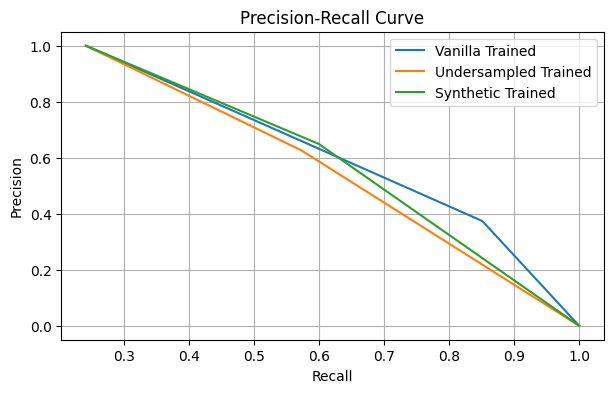

In [41]:
vanilla_prerec_curve = precision_recall_curve(y_test, pred_vanilla)
undersampled_prerec_curve = precision_recall_curve(y_test, pred_undersampled)
synthetic_prerec_curve = precision_recall_curve(y_test, pred_synthetic)

plt.figure(figsize=(7,4))
plt.plot(vanilla_prerec_curve[0], vanilla_prerec_curve[1], label='Vanilla Trained')
plt.plot(undersampled_prerec_curve[0], undersampled_prerec_curve[1], label='Undersampled Trained')
plt.plot(synthetic_prerec_curve[0], synthetic_prerec_curve[1], label='Synthetic Trained')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

### ROC AUC

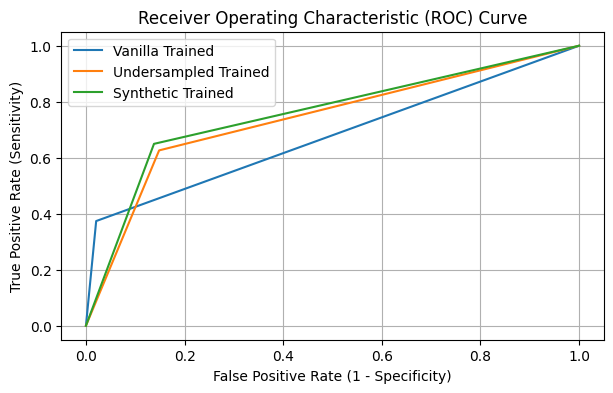

In [42]:
vanilla_roc_curve = roc_curve(y_test, pred_vanilla)
undersampled_roc_curve = roc_curve(y_test, pred_undersampled)
synthetic_roc_curve = roc_curve(y_test, pred_synthetic)

plt.figure(figsize=(7,4))
plt.plot(vanilla_roc_curve[0], vanilla_roc_curve[1], label='Vanilla Trained')
plt.plot(undersampled_roc_curve[0], undersampled_roc_curve[1], label='Undersampled Trained')
plt.plot(synthetic_roc_curve[0], synthetic_roc_curve[1], label='Synthetic Trained')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()